In [32]:
#@title Import libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import xgboost as xgb
import tensorflow as tf

# Data Organizing

In [33]:
#load_data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


In [34]:
type(x_train)

numpy.ndarray

In [35]:
#create labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

<Figure size 432x288 with 0 Axes>

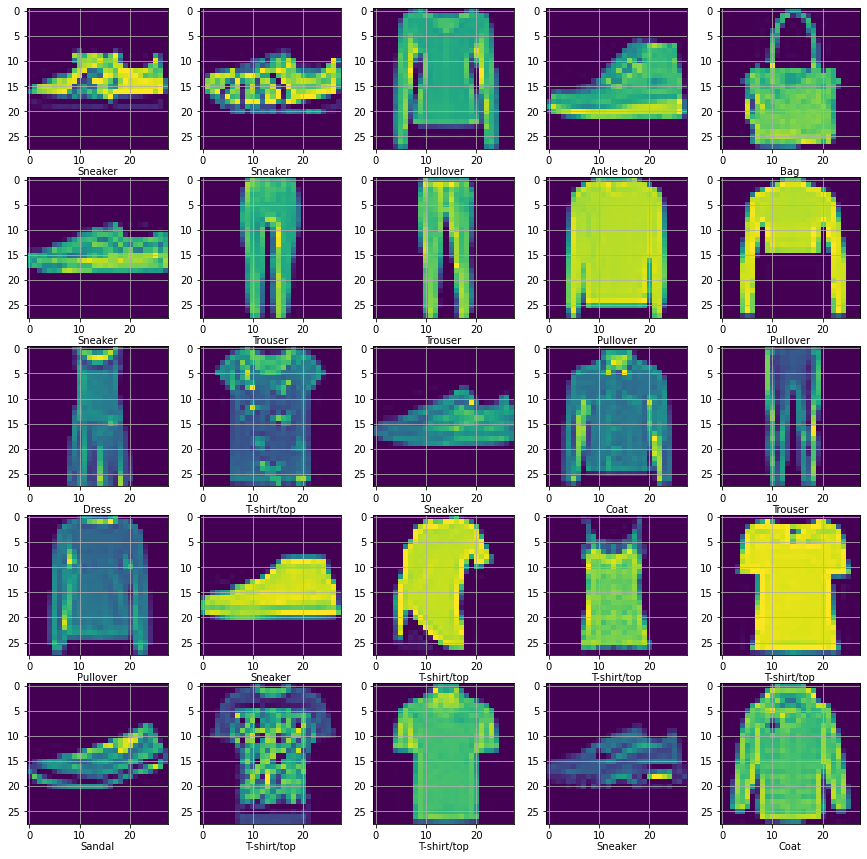

In [36]:
#data visualization
plt.figure()
plt.figure(figsize=(15,15))
for i in range(25):
  rand_no = np.random.randint(0,len(x_train))
  plt.subplot(5,5,i+1)  
  plt.imshow(x_train[rand_no])
  plt.grid(True)
  plt.xlabel(class_names[y_train[rand_no]],labelpad= 1)
plt.show()

In [37]:
#reshape the dataset from 4D to 2D
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
x_train.shape
#normalizing the pixels by unit normalization
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [38]:
#calc the number of principle components that save at least 0.95 of the variance
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.9) + 1
print(d)

137


In [39]:
pca = PCA(n_components = d)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [40]:
xgb_clf = xgb.XGBClassifier(eval_set=[(x_train, y_train)], early_stopping_rounds=2, use_label_encoder=False, objective="multi:softmax", eval_metric = 'mlogloss', n_jobs=-1)
xgb_clf.fit(x_train, y_train)

[19:15:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds", "eval_set" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=2,
              eval_metric='mlogloss',
              eval_set=[(array([[-8.01174771e-01,  2.08667487e+01, -1.29451358e+01, ...,
         2.12914920e-02, -1.39707935e-01,  7.18224312e-01],
       [ 1.70742060e+01, -4.96851249e+00, -2.07781956e+00, ...,
         3.41095465e-01,  5.73531125e-01,...
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [41]:
y_pred = xgb_clf.predict(x_test)
print("The accuracy of xgboost: ",accuracy_score(y_test, y_pred))

The accuracy of xgboost:  0.8716


In [42]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
DecisionTreeClassifier(), n_estimators=500,
max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf = Pipeline([
    ("pca", PCA(0.95)),
    ("bag", BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,max_samples=100, bootstrap=True, n_jobs=-1))])
bag_clf.fit(x_train, y_train)
y_pred_bag = bag_clf.predict(x_test)
print("The accuracy of random forest: ",accuracy_score(y_test, y_pred_bag))

The accuracy of random forest:  0.7493


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

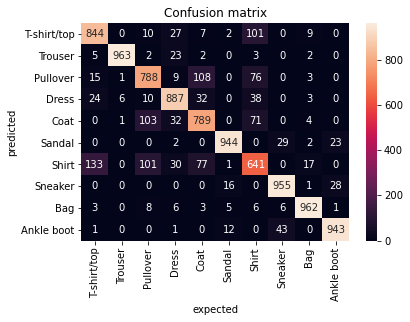

In [43]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, columns=class_names, index = class_names)
ax = sns.heatmap(df_cm, annot=True,  fmt="d")
ax.set_title('Confusion matrix')
ax.set_xlabel("expected")
ax.set_ylabel("predicted")
np.unique(y_train)